

# DDPM using the three middle slices of IXI T1 dataset

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

## Setup imports

In [1]:
import os
import shutil
import tempfile
import time
import glob

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from monai.data.utils import pad_list_data_collate
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import random

import nibabel as nib

from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler

#print_config()

In [2]:
DEVICE_TYPE = "cuda:1"

In [3]:
ROOT_DIR = "/home/fehrdelt/bettik/"
#ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"



In [4]:
set_determinism(0)

## Setup IXI Dataset and training and validation dataloaders
Inside dataset_IXI_T1_brain_extraction_registered_resampled_2nd_pass -> resampled with ANTS (worked better than SimpleITK) \
2D 240x240 middle slices of 3D ADC volumes

In [5]:
IMAGE_SIZE = 240

In [6]:
train_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/IXI_T1/train.csv")
train_images_path = []

with open(train_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):
        #print(line)
        train_images_path.append(ROOT_DIR+line[0])

val_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/IXI_T1/val.csv")
val_images_path = []

with open(val_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        val_images_path.append(ROOT_DIR+line[0])

test_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/IXI_T1/test.csv")
test_images_path = []

with open(test_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_images_path.append(ROOT_DIR+line[0])


464it [00:00, 20826.99it/s]
58it [00:00, 33577.59it/s]
59it [00:00, 1075.45it/s]


In [7]:
#train_datalist = sorted(train_images_path)
train_datalist = train_images_path

#val_datalist = sorted(val_images_path)
val_datalist = val_images_path

#val_datalist = sorted(val_images_path)
test_datalist = test_images_path

batch_size = 16
num_workers = 4


In [8]:
"""
for i, nifti_path in enumerate(train_datalist[:2]):
    img = nib.load(nifti_path).get_fdata()
    plt.figure(figsize=(6, 4))
    plt.hist(img[img >1].flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f"Histogram of Image {i+1}")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
"""

'\nfor i, nifti_path in enumerate(train_datalist[:2]):\n    img = nib.load(nifti_path).get_fdata()\n    plt.figure(figsize=(6, 4))\n    plt.hist(img[img >1].flatten(), bins=50, color=\'blue\', alpha=0.7)\n    plt.title(f"Histogram of Image {i+1}")\n    plt.xlabel("Intensity")\n    plt.ylabel("Frequency")\n    plt.grid(True)\n    plt.tight_layout()\n    plt.show()\n'

In [9]:
class Get2DSlice(transforms.Transform):
    """
    Fetch the middle slice of a 3D volume.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.offset = offset

    def __call__(self, data):
        #print(data.shape)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.offset]

In [10]:
class Get2DSliceWithRandomOffset(transforms.RandomizableTransform):
    """
    Fetch the middle slice of a 3D volume.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.offset = offset
        self.rand_offset = 0


    def randomize(self):
        super().randomize(None)
        self.rand_offset = random.randint(-1, 1)

    def __call__(self, data):
        #print(data.shape)
        self.randomize()

        #print(self.rand_offset)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.offset+self.rand_offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.offset+self.rand_offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.offset+self.rand_offset]

In [11]:

train_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.ScaleIntensity(minv=0.0, maxv=1.0),
        Get2DSliceWithRandomOffset(axis=1, offset=28), #28
        transforms.ScaleIntensity(minv=0.0, maxv=1.0),
        transforms.RandAffine(prob=0.2, rotate_range=(-0.15, 0.15)),
        transforms.RandScaleCrop(roi_scale=0.9, max_roi_scale=1.0, random_size=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.SpatialCrop(roi_center=(135,125), roi_size=(180,180))
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms) #TODO datalist[:32]
train_loader = DataLoader(
    #collate_fn=pad_list_data_collate: any tensors are centrally padded to match the shape of the biggest tensor in each dimension
    train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True, collate_fn=pad_list_data_collate
)



val_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.ScaleIntensity(minv=0.0, maxv=1.0),
        Get2DSlice(axis=1, offset=28),
        transforms.ScaleIntensity(minv=0.0, maxv=1.0),
        transforms.ResizeWithPadOrCrop(spatial_size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.SpatialCrop(roi_center=(135,125), roi_size=(180,180))
        #transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)



test_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.ScaleIntensity(minv=0.0, maxv=1.0),
        Get2DSlice(axis=1, offset=28),
        transforms.ScaleIntensity(minv=0.0, maxv=1.0),
        transforms.ResizeWithPadOrCrop(spatial_size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.SpatialCrop(roi_center=(135,125), roi_size=(180,180))
        #transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
test_ds = CacheDataset(data=test_datalist, transform=test_transforms)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:29<00:00,  1.98it/s]


### Visualisation of the training images

In [ ]:
print(len(train_loader.dataset))

58


In [13]:
print(train_datalist[3])

/home/fehrdelt/bettik/datasets/dataset_IXI_T1_brain_extraction_registered_resampled_2nd_pass/IXI264-Guys-0854-T1.nii.gz


batch shape: torch.Size([16, 1, 180, 180])


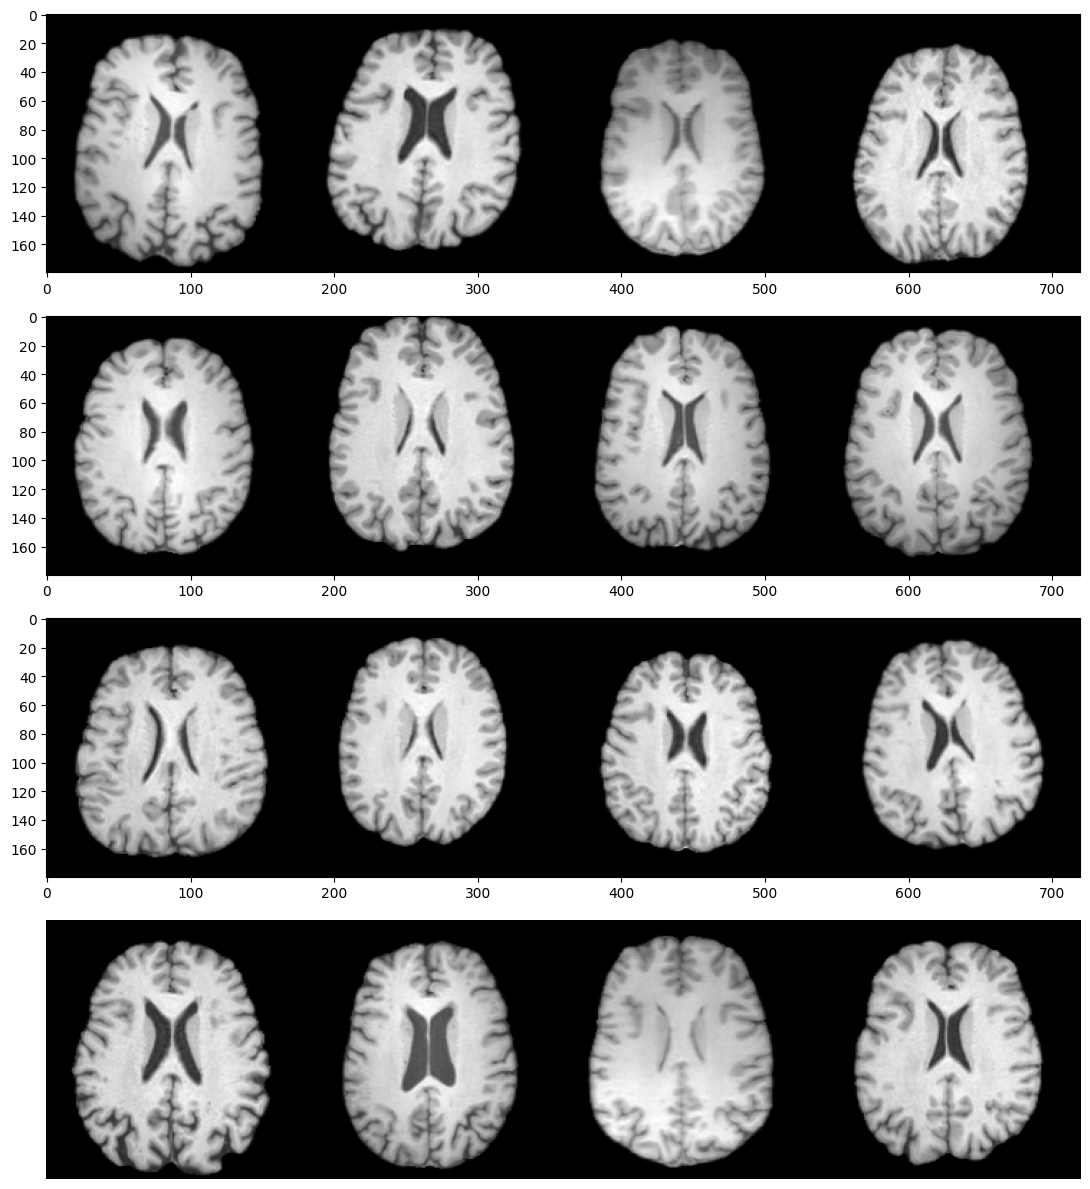

In [14]:

for i, batch in enumerate(train_loader):
    #print(i)
    if i==0:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


batch shape: torch.Size([16, 1, 180, 180])


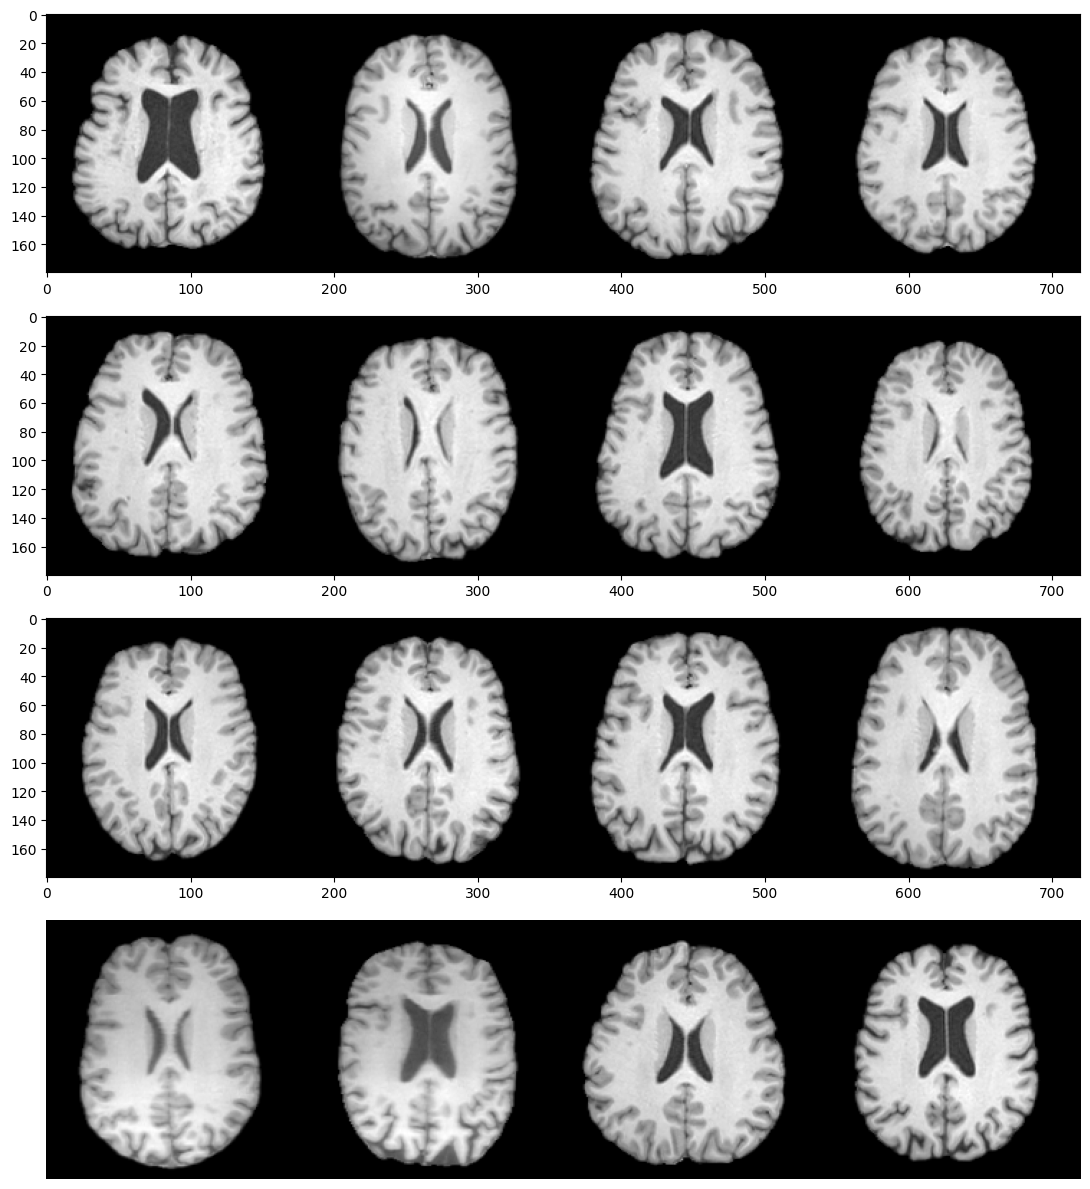

In [15]:

for i, batch in enumerate(val_loader):
    #print(i)
    if i==2:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 2nd and 3rd levels, each with 1 attention head.

In [16]:
device = torch.device(DEVICE_TYPE)
num_train_timesteps = 1000

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=(0, 128, 128),
)
model.to(device)

num_train_timesteps = 1000
scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training
Here, we are training our model for 75 epochs (training time: ~50 minutes).

Epoch 2: 100%|████████████| 29/29 [00:19<00:00,  1.47it/s, loss=0.666]


saved new best metric model
current epoch: 3 current val loss: 2.4014
best val loss: 2.4014 at epoch: 3


Epoch 5: 100%|████████████| 29/29 [00:19<00:00,  1.49it/s, loss=0.346]


saved new best metric model
current epoch: 6 current val loss: 1.2024
best val loss: 1.2024 at epoch: 6


Epoch 8: 100%|████████████| 29/29 [00:19<00:00,  1.48it/s, loss=0.161]


saved new best metric model
current epoch: 9 current val loss: 0.5803
best val loss: 0.5803 at epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.76it/s]


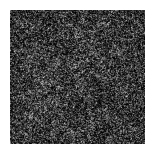

Epoch 11: 100%|██████████| 29/29 [00:19<00:00,  1.48it/s, loss=0.0732]


saved new best metric model
current epoch: 12 current val loss: 0.2557
best val loss: 0.2557 at epoch: 12


Epoch 14: 100%|██████████| 29/29 [00:19<00:00,  1.47it/s, loss=0.0337]


saved new best metric model
current epoch: 15 current val loss: 0.1475
best val loss: 0.1475 at epoch: 15


Epoch 17: 100%|██████████| 29/29 [00:19<00:00,  1.47it/s, loss=0.0199]


saved new best metric model
current epoch: 18 current val loss: 0.0908
best val loss: 0.0908 at epoch: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.77it/s]


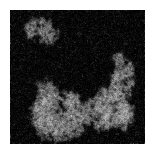

Epoch 20: 100%|██████████| 29/29 [00:19<00:00,  1.47it/s, loss=0.0166]


saved new best metric model
current epoch: 21 current val loss: 0.0518
best val loss: 0.0518 at epoch: 21


Epoch 23: 100%|██████████| 29/29 [00:19<00:00,  1.45it/s, loss=0.0139]


saved new best metric model
current epoch: 24 current val loss: 0.0472
best val loss: 0.0472 at epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.77it/s]


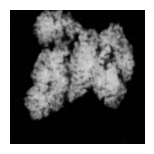

Epoch 29: 100%|██████████| 29/29 [00:19<00:00,  1.49it/s, loss=0.0116]


saved new best metric model
current epoch: 30 current val loss: 0.0208
best val loss: 0.0208 at epoch: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.78it/s]


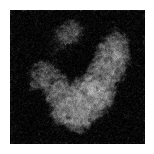

Epoch 38: 100%|█████████| 29/29 [00:19<00:00,  1.48it/s, loss=0.00955]


saved new best metric model
current epoch: 39 current val loss: 0.0187
best val loss: 0.0187 at epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.76it/s]


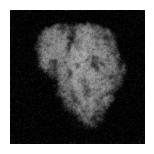

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.79it/s]


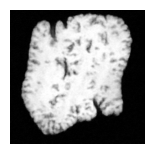

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.77it/s]


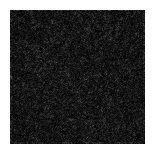

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.77it/s]


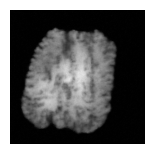

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.78it/s]


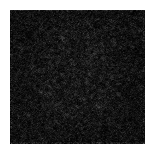

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.78it/s]


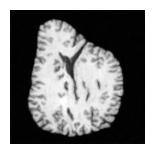

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.78it/s]


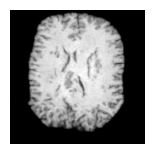

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.77it/s]


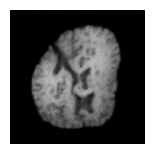

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.77it/s]


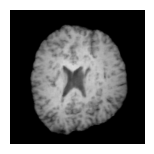

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.74it/s]


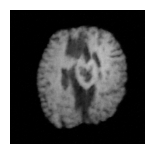

Epoch 128: 100%|████████| 29/29 [00:19<00:00,  1.47it/s, loss=0.00828]


saved new best metric model
current epoch: 129 current val loss: 0.0177
best val loss: 0.0177 at epoch: 129


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.75it/s]


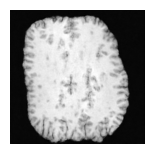

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.76it/s]


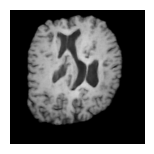

Epoch 146: 100%|████████| 29/29 [00:19<00:00,  1.48it/s, loss=0.00681]


saved new best metric model
current epoch: 147 current val loss: 0.0158
best val loss: 0.0158 at epoch: 147


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.77it/s]


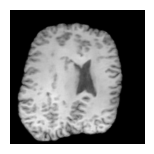

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.75it/s]


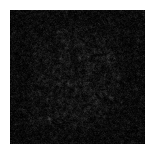

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.77it/s]


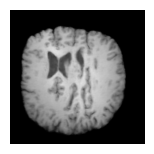

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.78it/s]


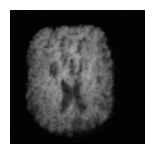

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.76it/s]


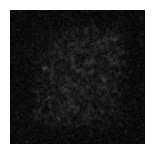

Epoch 197: 100%|████████| 29/29 [00:19<00:00,  1.46it/s, loss=0.00707]


saved new best metric model
current epoch: 198 current val loss: 0.0128
best val loss: 0.0128 at epoch: 198


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.76it/s]


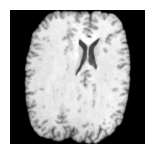

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.78it/s]


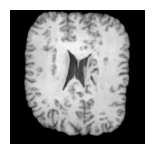

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.80it/s]


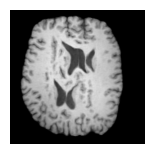

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


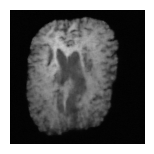

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


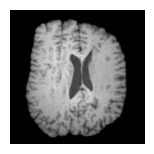

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


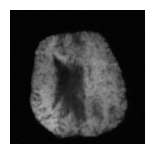

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


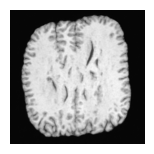

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


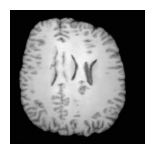

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.84it/s]


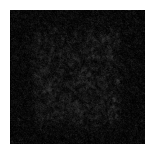

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.76it/s]


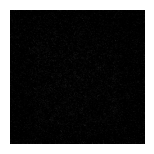

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


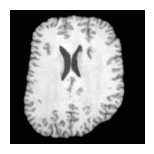

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


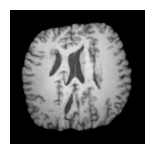

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


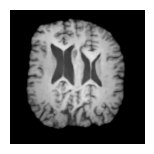

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


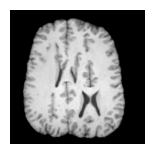

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


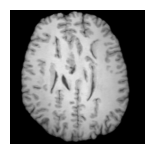

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


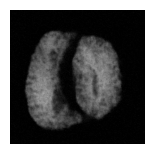

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


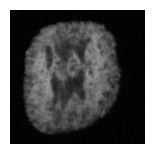

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


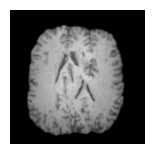

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


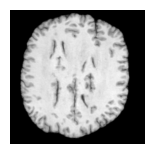

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


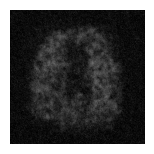

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


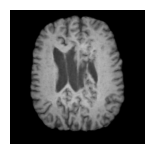

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


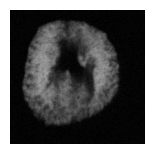

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


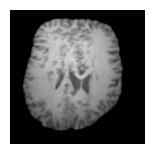

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


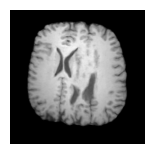

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


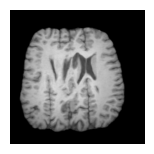

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


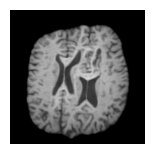

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


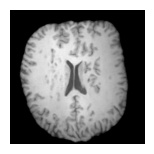

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


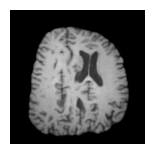

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


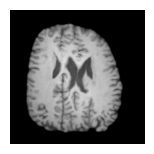

Epoch 455: 100%|████████| 29/29 [00:19<00:00,  1.49it/s, loss=0.00699]


saved new best metric model
current epoch: 456 current val loss: 0.0118
best val loss: 0.0118 at epoch: 456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.91it/s]


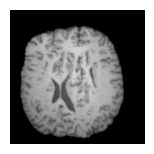

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


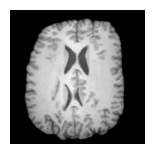

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.91it/s]


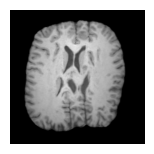

Epoch 485: 100%|████████| 29/29 [00:19<00:00,  1.48it/s, loss=0.00721]


saved new best metric model
current epoch: 486 current val loss: 0.0113
best val loss: 0.0113 at epoch: 486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


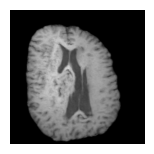

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


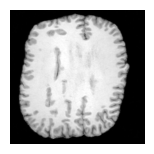

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


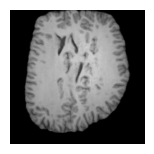

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


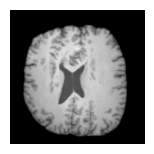

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


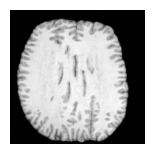

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


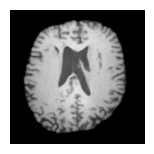

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.91it/s]


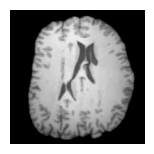

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.91it/s]


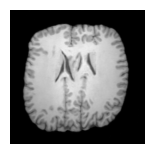

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


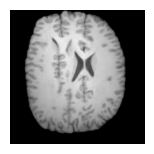

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


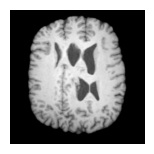

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


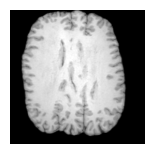

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


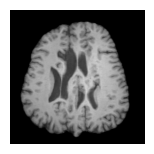

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


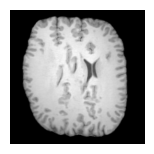

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


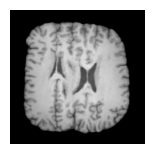

Epoch 611: 100%|████████| 29/29 [00:19<00:00,  1.48it/s, loss=0.00543]


saved new best metric model
current epoch: 612 current val loss: 0.0101
best val loss: 0.0101 at epoch: 612


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


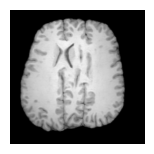

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


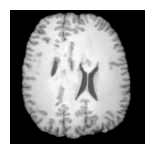

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


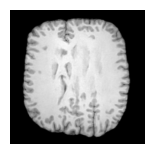

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


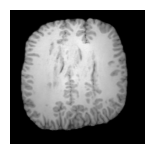

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


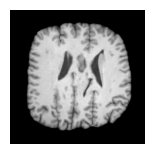

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


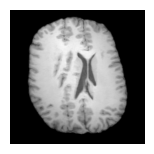

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


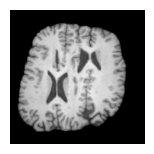

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


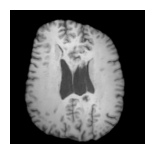

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


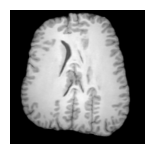

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.91it/s]


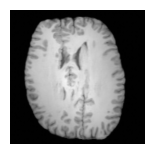

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


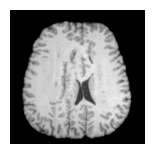

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


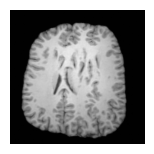

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


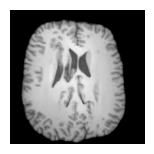

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


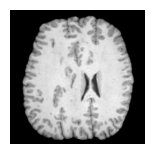

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


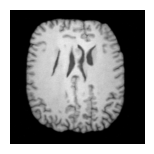

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


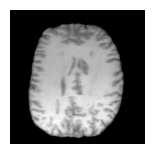

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


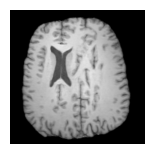

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


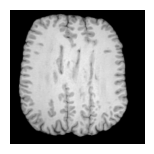

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


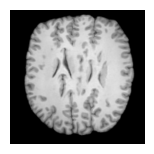

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


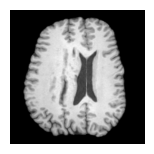

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


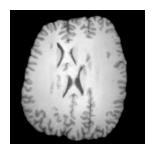

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.83it/s]


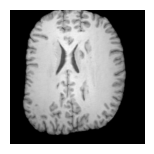

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


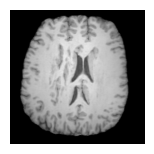

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.84it/s]


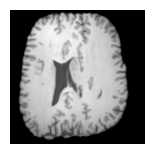

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


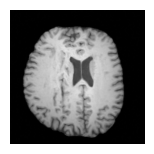

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


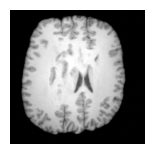

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


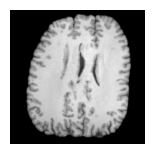

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


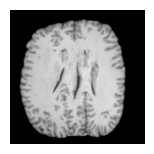

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


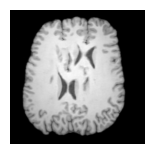

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


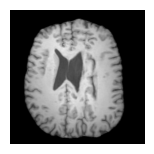

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


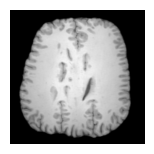

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


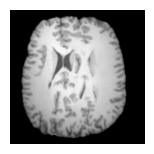

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


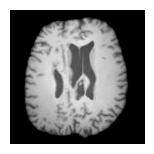

Epoch 905: 100%|████████| 29/29 [00:19<00:00,  1.49it/s, loss=0.00504]


saved new best metric model
current epoch: 906 current val loss: 0.0097
best val loss: 0.0097 at epoch: 906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


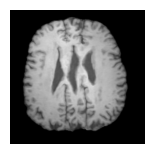

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.67it/s]


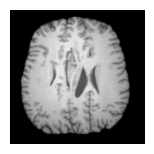

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


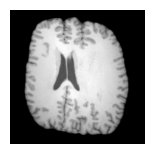

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


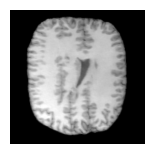

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


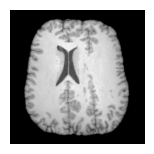

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.89it/s]


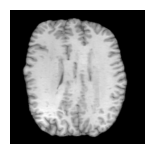

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


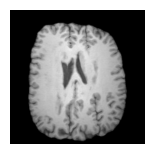

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


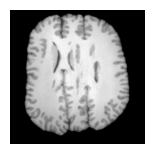

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


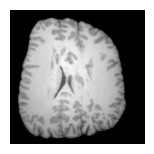

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


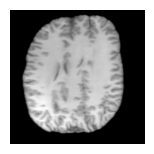

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


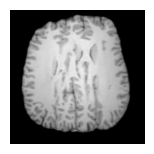

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


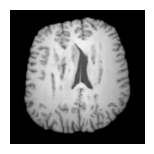

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


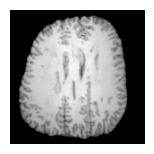

Epoch 1025: 100%|███████| 29/29 [00:19<00:00,  1.48it/s, loss=0.00584]


saved new best metric model
current epoch: 1026 current val loss: 0.0067
best val loss: 0.0067 at epoch: 1026


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


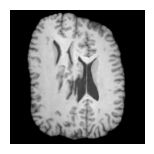

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


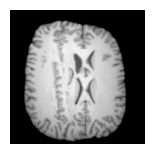

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


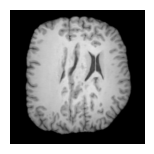

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.85it/s]


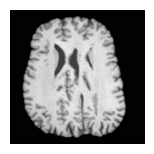

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


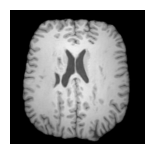

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


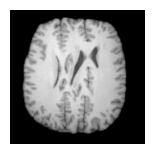

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


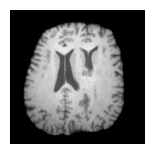

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


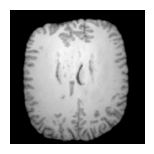

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


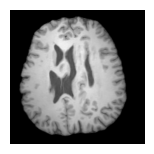

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.90it/s]


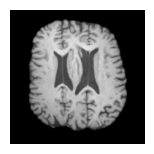

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


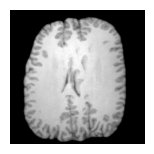

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


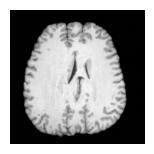

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


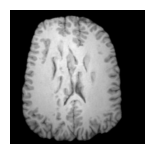

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


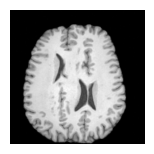

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.88it/s]


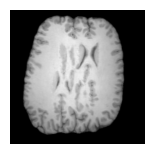

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.86it/s]


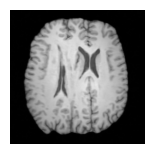

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.85it/s]


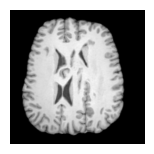

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.84it/s]


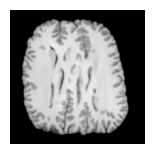

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.85it/s]


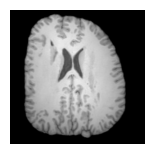

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


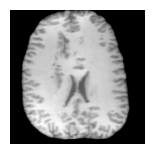

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.84it/s]


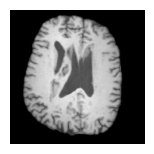

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.87it/s]


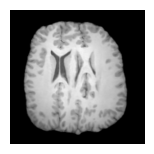

Epoch 1219:  38%|██▋    | 11/29 [00:07<00:11,  1.52it/s, loss=0.00601]

In [ ]:
writer = SummaryWriter(ROOT_DIR+"Code/Tensorboard/IXI_T1_3slices_per_patient")

max_epochs = 3000
val_interval = 3
epoch_loss_list = []
val_epoch_loss_list = []

best_val_epoch_loss = np.inf
best_val_epoch = 0

scaler = GradScaler(DEVICE_TYPE)
total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=DEVICE_TYPE, enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        epoch_len = len(train_ds)
        

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

    epoch_loss_list.append(epoch_loss / (step + 1))
    writer.add_scalar("train_loss", epoch_loss / (step + 1), epoch)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch.to(device)
            with torch.no_grad(), autocast(device_type=DEVICE_TYPE, enabled=True):
                noise = torch.randn_like(images).to(device)
                timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()

            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})

        val_epoch_loss_list.append(val_epoch_loss / (step + 1))
        writer.add_scalar("val_loss", val_epoch_loss / (step + 1), epoch)   # moi

        if val_epoch_loss < best_val_epoch_loss:
            best_val_epoch_loss = val_epoch_loss
            best_val_epoch = epoch + 1
            torch.save(
                model.state_dict(),
                os.path.join(ROOT_DIR+"Code/Best_models/2d_ddpm_tutorial", "T1_best_metric_model_IXI_3slices_per_patient.pth"),
            )
            print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_epoch_loss:.4f}"
                f"\nbest val loss: {best_val_epoch_loss:.4f}"
                f" at epoch: {best_val_epoch}"
            )


        if (epoch + 1) % (val_interval*3) == 0:
            # Sampling image during training
            noise = torch.randn((1, 1, IMAGE_SIZE, IMAGE_SIZE)) # ! enfait c'est 180, 180
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(device_type=DEVICE_TYPE, enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

### Forward then backward sampling from image

In [17]:
model.load_state_dict(torch.load(os.path.join(ROOT_DIR+"Code/Best_models/2d_ddpm_tutorial", "T1_best_metric_model_IXI_3slices_per_patient.pth"), map_location=DEVICE_TYPE))
model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): DiffusionUNetResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): DiffusionUne

In [18]:
test_image = np.zeros((1, 1, 128, 128))

#for i, batch in enumerate(train_loader):
for i, batch in enumerate(test_loader):
    print(np.max(batch[0]))
    if i==0:
        images = batch.to(device)
        test_image = images
        break

1.0


In [19]:
NOISE_STEPS = 150 #150

In [20]:

scheduler.set_timesteps(num_inference_steps=1000)

num_test_timesteps = 200 # 1000 like num_train_timesteps

timesteps = torch.FloatTensor([NOISE_STEPS for i in range(test_image.shape[0])]).to(device).long()

noise = torch.randn_like(test_image).to(device)

noisy_image = scheduler.add_noise(original_samples=test_image, noise=noise, timesteps=timesteps)

In [21]:
test_image.shape

torch.Size([16, 1, 180, 180])

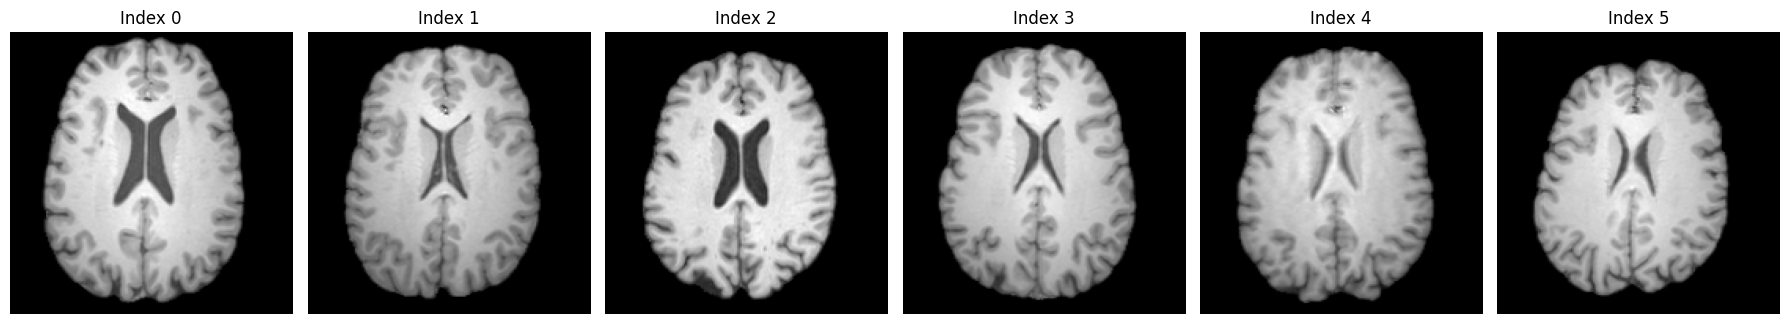

In [22]:
fig, axs = plt.subplots(1, 6, figsize=(18, 6))

for i in range(6):
    axs[i].imshow(test_image[i, 0].cpu(), cmap="gray", vmin=0, vmax=1)
    axs[i].axis("off")
    axs[i].title.set_text(f"Index {i}")

plt.tight_layout()
plt.show()

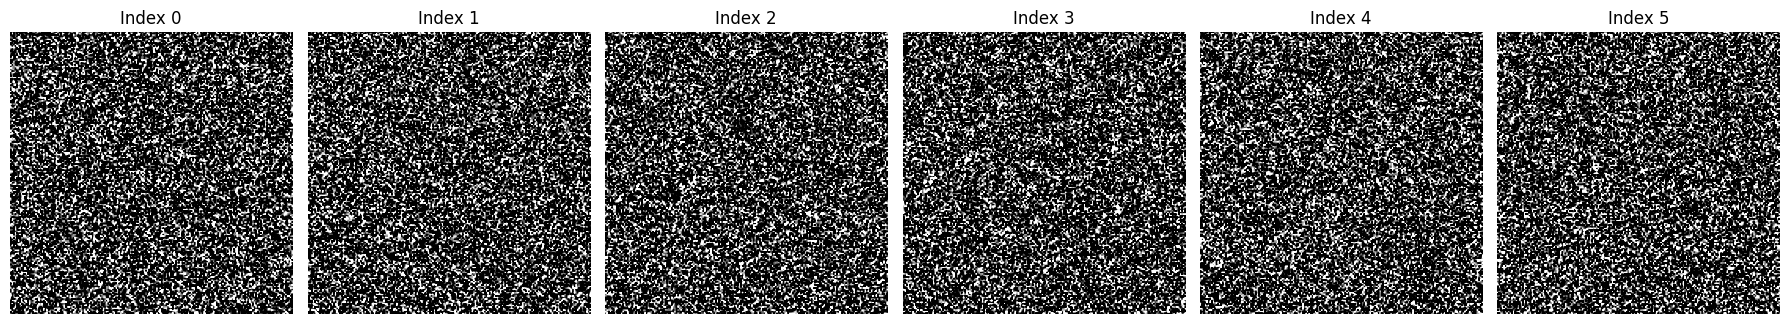

In [23]:
fig, axs = plt.subplots(1, 6, figsize=(18, 6))

for i in range(6):
    axs[i].imshow(noise[i, 0].cpu(), cmap="gray", vmin=0, vmax=1)
    axs[i].axis("off")
    axs[i].title.set_text(f"Index {i}")

plt.tight_layout()
plt.show()

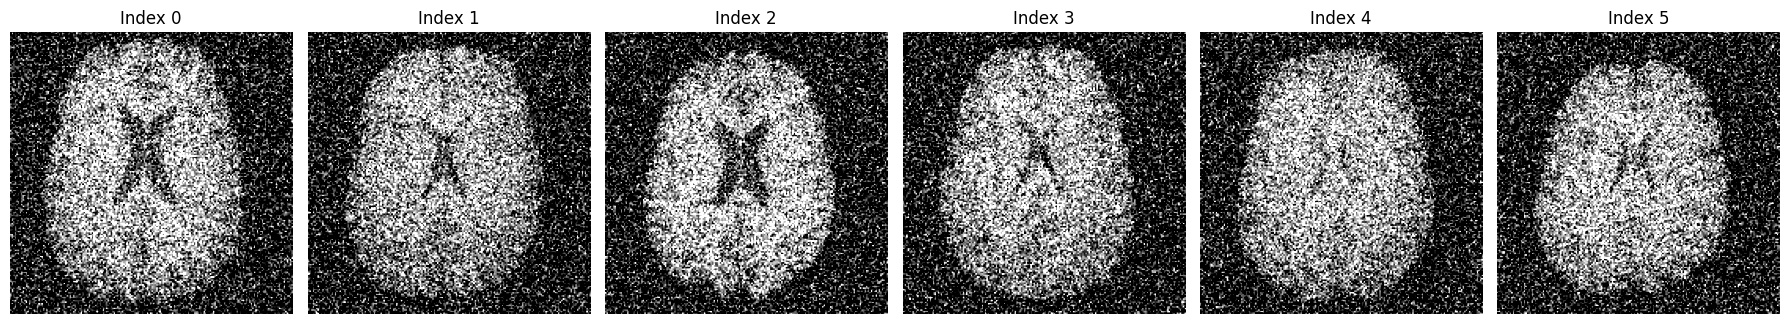

In [24]:
fig, axs = plt.subplots(1, 6, figsize=(18, 6))

for i in range(6):
    axs[i].imshow(noisy_image[i, 0].cpu(), cmap="gray", vmin=0, vmax=1)
    axs[i].axis("off")
    axs[i].title.set_text(f"Index {i}")

plt.tight_layout()
plt.show()

Sample from noisy image

In [25]:
from functools import partial
from monai.networks.nets import SPADEDiffusionModelUNet

intermediate_steps = 10



num_infer_timesteps = 100
infer_scheduler = DDPMScheduler(num_train_timesteps=num_infer_timesteps)


@torch.no_grad()
def my_sample(image, progress_bar=True):
    
    
    all_next_timesteps = torch.cat((scheduler.timesteps[1:], torch.tensor([0], dtype=infer_scheduler.timesteps.dtype)))

    if progress_bar:
        progress_bar = tqdm(
            zip(infer_scheduler.timesteps, all_next_timesteps),
            total=min(len(infer_scheduler.timesteps), len(all_next_timesteps)),
        )
    else:
        progress_bar = zip(infer_scheduler.timesteps, all_next_timesteps)
            
    intermediates = []
            
    for t, next_t in progress_bar:          # va de num_infer_timesteps à 0
        # 1. predict noise model_output
        diffusion_model = model
        
        model_output = diffusion_model(
            image, timesteps=torch.Tensor((t,)).to(noise.device), context=None
        )
        
        # 2. compute previous image: x_t -> x_t-1
        
        image, _ = infer_scheduler.step(model_output, t, image)
        
        if t % intermediate_steps == 0:
            intermediates.append(image)
    
    return image, intermediates



In [26]:

with autocast(device_type=DEVICE_TYPE, enabled=True):
    infered_image, intermediates = my_sample(noisy_image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.31it/s]


In [27]:
chain = torch.cat(intermediates, dim=-1)

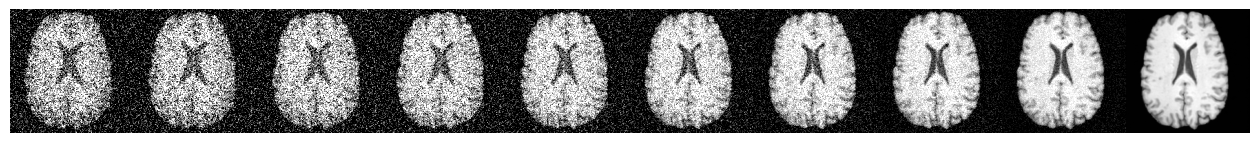

In [28]:
plt.figure(figsize=(16, 10))
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
#plt.tight_layout()
plt.axis("off")
plt.show()

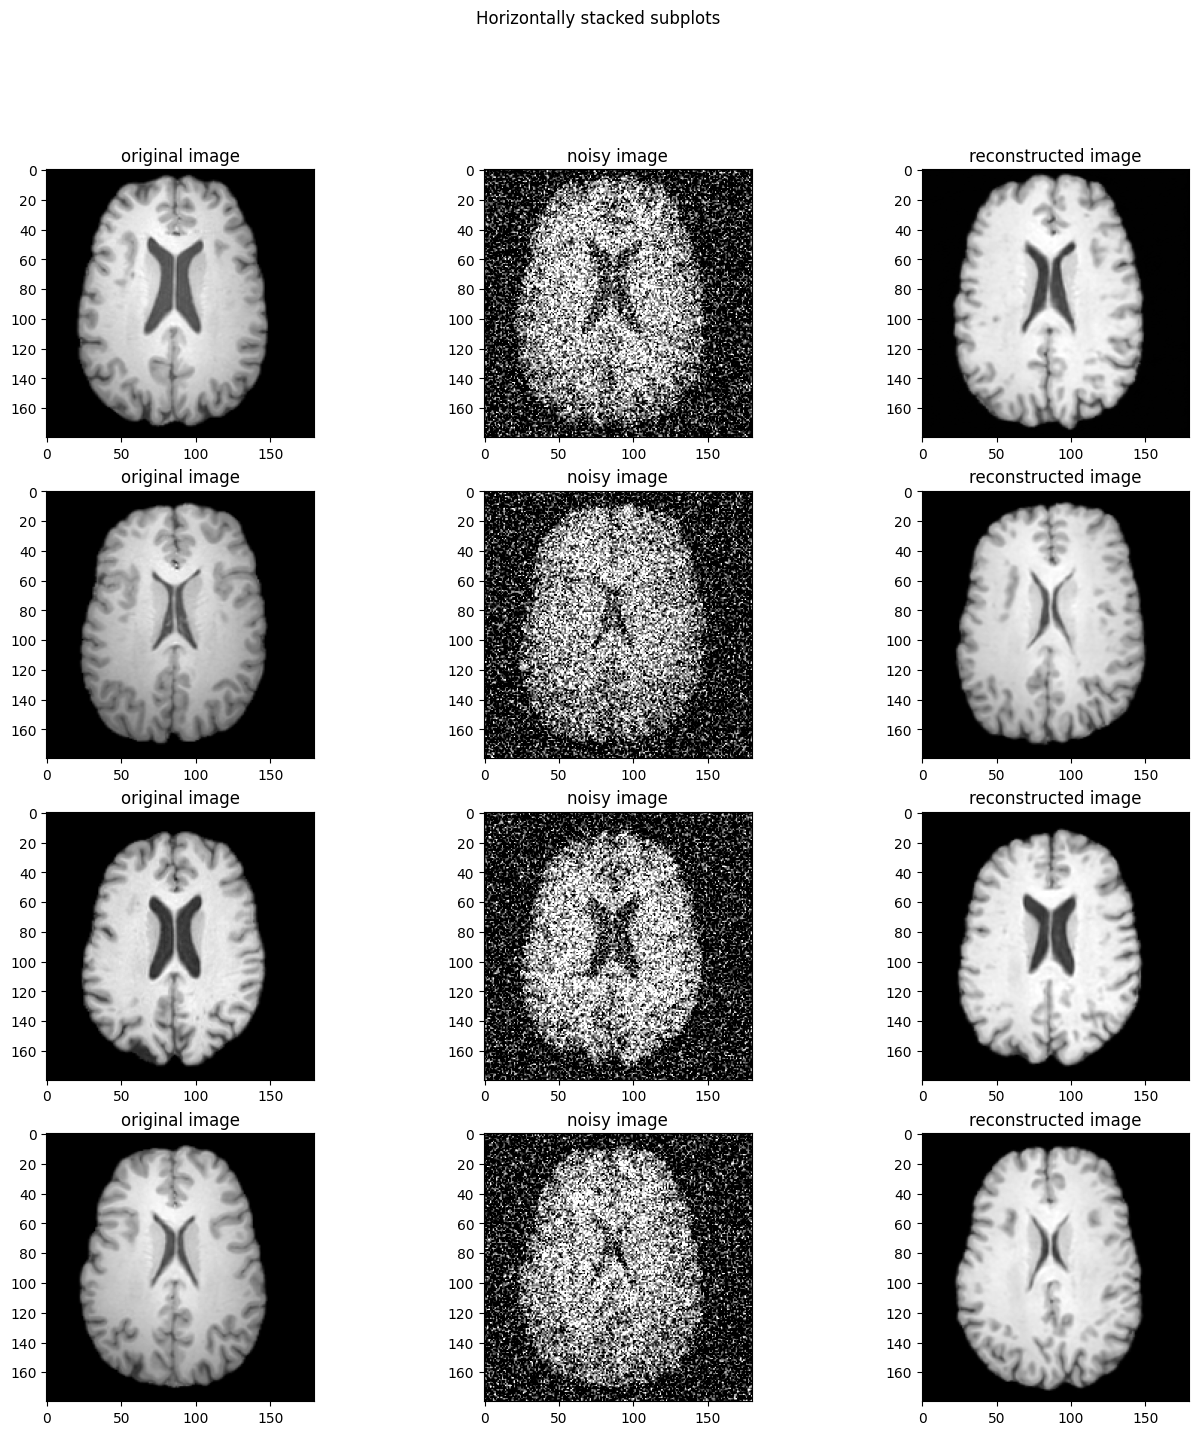

In [29]:
fig, axs = plt.subplots(4, 3, figsize=(16,16))

fig.suptitle('Horizontally stacked subplots')
axs[0, 0].imshow(test_image[0,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[0, 0].title.set_text('original image')
axs[0, 1].imshow(noisy_image[0,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[0, 1].title.set_text('noisy image')
axs[0, 2].imshow(infered_image[0,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[0, 2].title.set_text('reconstructed image')

axs[1, 0].imshow(test_image[1,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[1, 0].title.set_text('original image')
axs[1, 1].imshow(noisy_image[1,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[1, 1].title.set_text('noisy image')
axs[1, 2].imshow(infered_image[1,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[1, 2].title.set_text('reconstructed image')

axs[2, 0].imshow(test_image[2,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[2, 0].title.set_text('original image')
axs[2, 1].imshow(noisy_image[2,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[2, 1].title.set_text('noisy image')
axs[2, 2].imshow(infered_image[2,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[2, 2].title.set_text('reconstructed image')

axs[3, 0].imshow(test_image[3,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[3, 0].title.set_text('original image')
axs[3, 1].imshow(noisy_image[3,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[3, 1].title.set_text('noisy image')
axs[3, 2].imshow(infered_image[3,0].cpu(), vmin=0, vmax=1, cmap="gray")
axs[3, 2].title.set_text('reconstructed image')

### Validation Reconstruction Quality: PSNR & SSIM

In [30]:
from monai.metrics import PSNRMetric, SSIMMetric, MultiScaleSSIMMetric

In [31]:
ms_ssim = MultiScaleSSIMMetric(spatial_dims=2, data_range=1.0)
ssim = SSIMMetric(spatial_dims=2, data_range=1.0)

psnr_metric = PSNRMetric(max_val=1.0)

print("Computing MS-SSIM & PSNR...")
ms_ssim_list = []
ssim_list = []

psnr_list = []

pbar = tqdm(enumerate(val_loader), total=len(val_loader))
for step, batch in pbar:
    test_image = batch.to(device)


    scheduler.set_timesteps(num_inference_steps=1000)

    num_test_timesteps = 200 # 1000 like num_train_timesteps

    timesteps = torch.FloatTensor([NOISE_STEPS for i in range(test_image.shape[0])]).to(device).long()

    noise = torch.randn_like(test_image).to(device)

    noisy_image = scheduler.add_noise(original_samples=test_image, noise=noise, timesteps=timesteps)

    with autocast(device_type=DEVICE_TYPE, enabled=True):
        infered_image, intermediates = my_sample(noisy_image, progress_bar=False)

    #ms_ssim_list.append(ms_ssim(test_image, infered_image).item())
    #print(ssim(test_image, infered_image).detach().cpu().numpy())
    #print(ssim(test_image, infered_image).detach().cpu().numpy().flatten())
    ssim_list.append(np.mean(ssim(test_image, infered_image).detach().cpu().numpy().flatten()))

    #print(psnr_metric(infered_image/np.max(infered_image), test_image/np.max(infered_image)).detach().cpu().numpy().flatten())
    psnr_list.append(psnr_metric(infered_image/np.max(infered_image), test_image/np.max(infered_image)).detach().cpu().numpy().flatten())
    
    pbar.update()

print(f"Mean PSNR: {np.mean(psnr_list[0]):.6f}")
print(f"Mean SSIM: {np.mean(ssim_list):.6f}")

#ms_ssim_list = np.array(ms_ssim_list)
#print(f"Mean MS-SSIM: {ms_ssim_list.mean():.6f}")

Computing MS-SSIM & PSNR...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:23<00:00, 20.92s/it]

Mean PSNR: 18.673985
Mean SSIM: 0.661208


In [32]:
print(np.mean(ssim(test_image, infered_image).detach().cpu().numpy().flatten()))

0.66841996


In [33]:
print(ssim_list)

[0.6455602, 0.6631823, 0.66766787, 0.66841996]


In [34]:
print(ms_ssim_list)

[]


### Anomaly Map
https://github.com/Project-MONAI/tutorials/blob/main/generation/anomaly_detection/anomaly_detection_with_transformers.ipynb